#📌 Extracción

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Cargar los datos desde JSON
data = pd.read_json("TelecomX_Data.json")
df = pd.json_normalize(data.to_dict(orient="records"))
df.head()


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


#🔧 Transformación

In [9]:
# Revisar estructura y valores faltantes
df.info()
df.isnull().sum()

# Convertir cargos totales a numérico
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')

# Eliminar registros con churn vacío
df = df[df['Churn'].isin(['Yes', 'No'])]
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

df.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

(7043, 21)

#📊 Carga y análisis

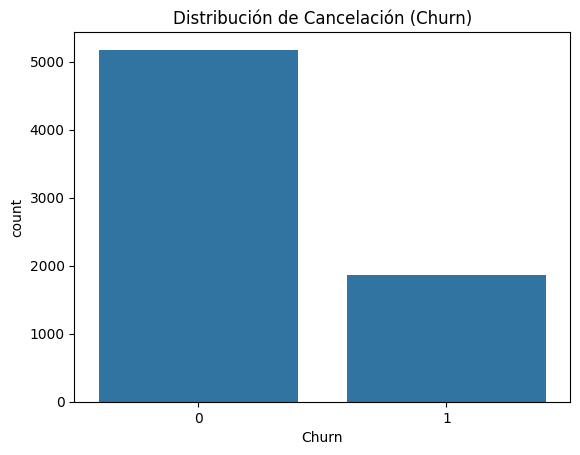

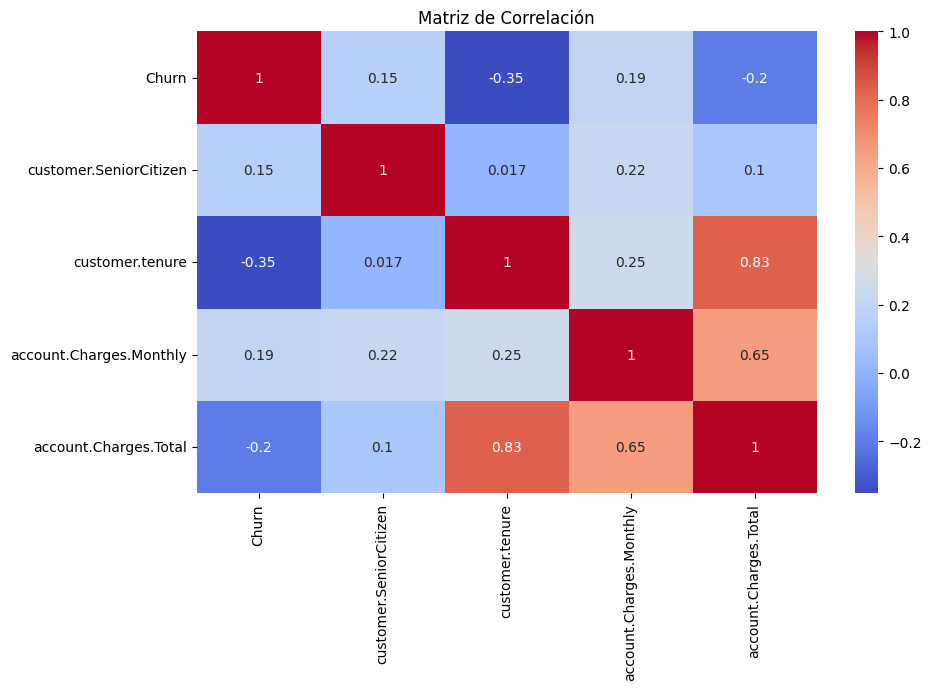

In [10]:
# Distribución de churn
sns.countplot(x=df['Churn'])
plt.title("Distribución de Cancelación (Churn)")
plt.show()

# Correlación entre variables numéricas
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()

In [11]:
# Codificación de variables categóricas
cat_cols = df.select_dtypes(include="object").columns
df_encoded = df.copy()
df_encoded[cat_cols] = df_encoded[cat_cols].apply(LabelEncoder().fit_transform)

# Definir X e y
X = df_encoded.drop(columns=["customerID", "Churn"])
y = df_encoded["Churn"]

# División en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [13]:
# Modelo 1: Regresión Logística con pipeline (imputación + escalado)
log_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

log_pipeline.fit(X_train, y_train)
y_pred_log = log_pipeline.predict(X_test)

print("🔹 Regresión Logística")
print(classification_report(y_test, y_pred_log))

🔹 Regresión Logística
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1552
           1       0.62      0.54      0.58       561

    accuracy                           0.79      2113
   macro avg       0.73      0.71      0.72      2113
weighted avg       0.78      0.79      0.79      2113



🔹 Random Forest
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1552
           1       0.61      0.47      0.53       561

    accuracy                           0.78      2113
   macro avg       0.72      0.68      0.69      2113
weighted avg       0.77      0.78      0.77      2113



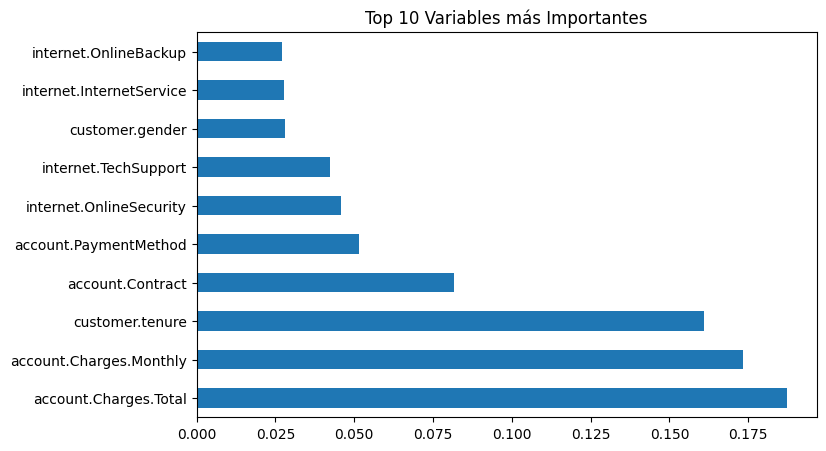

In [14]:
#  Modelo 2: Random Forest con pipeline (imputación)
rf_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("🔹 Random Forest")
print(classification_report(y_test, y_pred_rf))

# Importancia de variables
rf_model = rf_pipeline.named_steps["model"]
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.head(10).plot(kind="barh", figsize=(8,5), title="Top 10 Variables más Importantes")
plt.show()


#📄Informe final


### 📌 Conclusiones Estratégicas

- **Factores de mayor riesgo de churn**:
  - Contratos **mensuales** presentan mayor probabilidad de cancelación.
  - Pagos mediante **Electronic Check** muestran menor fidelización.
  - Clientes de **Fiber Optic** sin servicios adicionales (seguridad, soporte, backup) presentan mayor riesgo.
  - Clientes con baja **antigüedad (tenure < 12 meses)** tienen alta tasa de churn.

- **Estrategias recomendadas**:
  - Incentivar contratos de largo plazo (1 o 2 años).
  - Promociones y descuentos por uso de pagos automáticos.
  - Programas de fidelización para clientes con poca antigüedad.
  - Bundles de servicios adicionales para clientes con fibra óptica.
